In [34]:
import pandas as pd
import numpy as np
import xgboost as xgb
import sklearn.model_selection
from sklearn.metrics import (
    classification_report,
    roc_auc_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve,
)
import matplotlib.pyplot as plt
import seaborn as sns

In [35]:
df = pd.read_csv("../FINAL_FINAL_FINAL.csv")

In [36]:
df.drop(inplace=True,columns=['els','fcs','mig','mil','iep','act'])
df.drop(columns=['schlcode'],inplace=True)

exit_code_desc
0    290596
1      7756
Name: count, dtype: int64

In [37]:
df.dtypes

aig                   object
eds                   object
ethnic                object
hms                   object
lea                   object
mastid               float64
sex                   object
swd                   object
exit_code_desc        object
absent_pc_grade_3    float64
absent_pc_grade_4    float64
absent_pc_grade_5    float64
absent_pc_grade_6    float64
absent_pc_grade_7    float64
absent_pc_grade_8    float64
pc_MA04              float64
pc_MA05              float64
pc_MA06              float64
pc_MA07              float64
pc_MA08              float64
pc_RD04              float64
pc_RD05              float64
pc_RD06              float64
pc_RD07              float64
pc_RD08              float64
pc_SC05              float64
pc_SC08              float64
dtype: object

In [38]:
subgroup_vars = ['aig','eds','hms','swd']

df[subgroup_vars] = df[subgroup_vars].replace({'Y': 1, 'N': 0})


/var/folders/dk/2mw0y5w91dggrsnrpxb04jv80000gn/T/ipykernel_90398/2254881556.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[subgroup_vars] = df[subgroup_vars].replace({'Y': 1, 'N': 0})


In [39]:
df['sex_M'] = df['sex'].replace({'M':1,'F':0})
df.drop(columns=['sex'],inplace=True)

/var/folders/dk/2mw0y5w91dggrsnrpxb04jv80000gn/T/ipykernel_90398/2880232181.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['sex_M'] = df['sex'].replace({'M':1,'F':0})


In [40]:
df['exit_code_desc'] = df['exit_code_desc'].replace({'Graduated':0,'Dropped Out':1})

/var/folders/dk/2mw0y5w91dggrsnrpxb04jv80000gn/T/ipykernel_90398/3569188986.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['exit_code_desc'] = df['exit_code_desc'].replace({'Graduated':0,'Dropped Out':1})


In [41]:

lea_counts = df['lea'].value_counts()


valid_leas = lea_counts[lea_counts > 1000].index


df = df[df['lea'].isin(valid_leas)]

df['exit_code_desc'].value_counts()

In [42]:
# One-hot encode 'lea' and 'ethnic' columns
df = pd.get_dummies(df, columns=['lea', 'ethnic'], prefix=['lea', 'ethnic'], dtype=int)
#df = pd.get_dummies(df, columns=['ethnic'], prefix=['ethnic'], dtype=int)
#df = df.drop(columns=['lea']) #lets try this

In [43]:
df.dtypes

aig                    int64
eds                    int64
hms                    int64
mastid               float64
swd                    int64
exit_code_desc         int64
absent_pc_grade_3    float64
absent_pc_grade_4    float64
absent_pc_grade_5    float64
absent_pc_grade_6    float64
absent_pc_grade_7    float64
absent_pc_grade_8    float64
pc_MA04              float64
pc_MA05              float64
pc_MA06              float64
pc_MA07              float64
pc_MA08              float64
pc_RD04              float64
pc_RD05              float64
pc_RD06              float64
pc_RD07              float64
pc_RD08              float64
pc_SC05              float64
pc_SC08              float64
sex_M                  int64
ethnic_A               int64
ethnic_B               int64
ethnic_H               int64
ethnic_I               int64
ethnic_M               int64
ethnic_P               int64
ethnic_W               int64
dtype: object

In [44]:
X = df.drop('exit_code_desc',axis=1).copy()
y = df['exit_code_desc'].copy()
X_temp, X_test, y_temp, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size=0.10, stratify=y, random_state=42
)
val_frac = 0.10 / 0.90
X_train, X_val, y_train, y_val = sklearn.model_selection.train_test_split(
    X_temp, y_temp, test_size=val_frac, stratify=y_temp, random_state=42
)



# Clean infinite values
for df_ in [X_train, X_val, X_test]:
    df_.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaNs
X_train.dropna(inplace=True)
X_val.dropna(inplace=True)
X_test.dropna(inplace=True)

# Align labels
y_train = y_train.loc[X_train.index]
y_val = y_val.loc[X_val.index]
y_test = y_test.loc[X_test.index]

# Converting to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)
# Computing imbalance weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
# Defining the hyperparameter grid
param_grid = {
    "max_depth": [3, 5, 7],
    "eta": [0.1, 0.01],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0],
    "objective": "binary:logistic",
    "scale_pos_weight": scale_pos_weight,
    "eval_metric": "auc",
}

best_score = 0
best_params = None
best_rounds = 0
# Manual grid search with early stopping
for max_depth in param_grid["max_depth"]:
    for eta in param_grid["eta"]:
        for subsample in param_grid["subsample"]:
            for colsample in param_grid["colsample_bytree"]:
                params = {
                    "max_depth": max_depth,
                    "eta": eta,
                    "subsample": subsample,
                    "colsample_bytree": colsample,
                    "objective": "binary:logistic",
                    "scale_pos_weight": scale_pos_weight,
                    "eval_metric": "auc",
                }
                evals = [(dtrain, "train"), (dval, "val")]
                bst = xgb.train(
                    params,
                    dtrain,
                    num_boost_round=500,
                    evals=evals,
                    early_stopping_rounds=10,
                    verbose_eval=False,
                )
                if bst.best_score > best_score:
                    best_score = bst.best_score
                    best_params = params
                    best_rounds = bst.best_iteration

print("Best validation AUC:", best_score)
print("Best params:", best_params)
print("Best rounds:", best_rounds)
# Retraining the final model on train + validation
dtrain_full = xgb.DMatrix(
    pd.concat([X_train, X_val], axis=0), label=pd.concat([y_train, y_val], axis=0)
)
bst_final = xgb.train(best_params, dtrain_full, num_boost_round=best_rounds)

Best validation AUC: 0.8605236348673583
Best params: {'max_depth': 3, 'eta': 0.1, 'subsample': 1.0, 'colsample_bytree': 0.8, 'objective': 'binary:logistic', 'scale_pos_weight': np.float64(37.45752055457037), 'eval_metric': 'auc'}
Best rounds: 192



Test Metrics:
              precision    recall  f1-score   support

           0       0.99      0.78      0.87     29029
           1       0.09      0.78      0.16       776

    accuracy                           0.78     29805
   macro avg       0.54      0.78      0.52     29805
weighted avg       0.97      0.78      0.86     29805

Test ROC AUC: 0.8584012858808451
Confusion Matrix:
 [[22665  6364]
 [  170   606]]


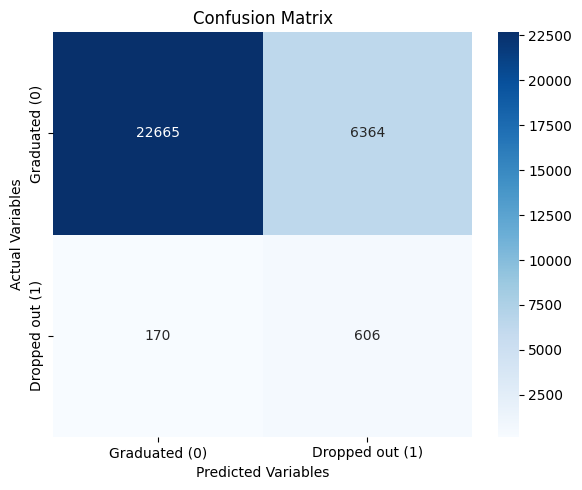

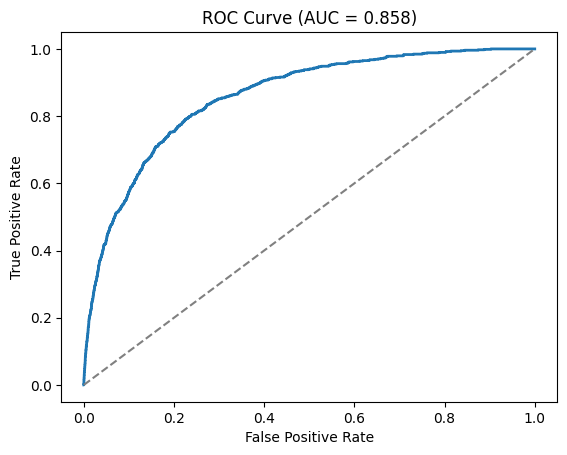

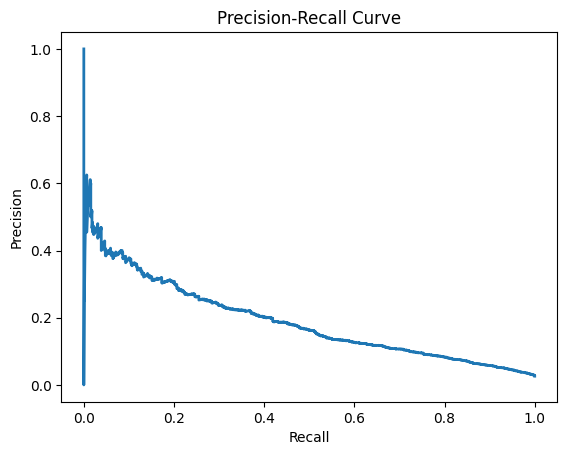

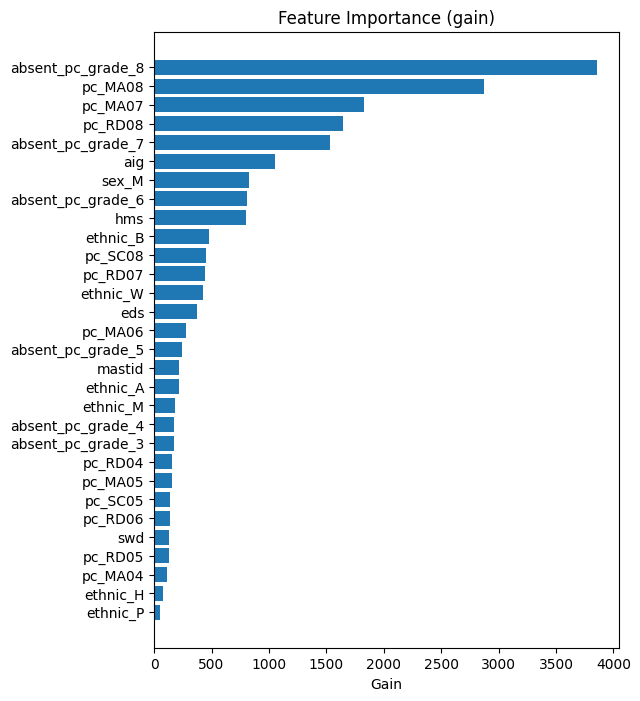

In [45]:
# Evaluating on the test set
y_test_proba = bst_final.predict(dtest)
y_test_pred = (y_test_proba > 0.5).astype(int)

print("\nTest Metrics:")
print(classification_report(y_test, y_test_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_test_proba))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))
# Computing confusion matrix
cm = confusion_matrix(y_test, y_test_pred)

# Ploting
plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    cbar=True,
    xticklabels=["Graduated (0)", "Dropped out (1)"],
    yticklabels=["Graduated (0)", "Dropped out (1)"],
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Variables")
plt.ylabel("Actual Variables")
plt.tight_layout()
plt.show()


# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_test_proba)
plt.figure()
plt.plot(fpr, tpr, lw=2)
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve (AUC = {:.3f})".format(roc_auc_score(y_test, y_test_proba)))
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

# Precision-Recall Curve
prec, rec, _ = precision_recall_curve(y_test, y_test_proba)
plt.figure()
plt.plot(rec, prec, lw=2)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

# Feature Importance (gain)
importance = bst_final.get_score(importance_type="gain")
items = sorted(importance.items(), key=lambda x: x[1], reverse=True)
feat, score = zip(*items)
plt.figure(figsize=(6, 8))
plt.barh(feat, score)
plt.gca().invert_yaxis()
plt.title("Feature Importance (gain)")
plt.xlabel("Gain")
plt.show()

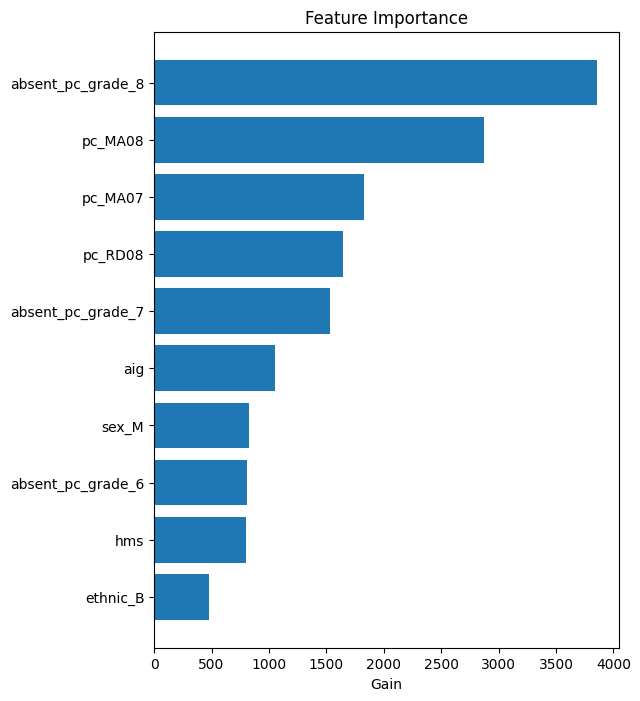

In [46]:
# Feature Importance (gain)
importance = bst_final.get_score(importance_type="gain")
items = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:10]
feat, score = zip(*items)
plt.figure(figsize=(6, 8))
plt.barh(feat, score)
plt.gca().invert_yaxis()
plt.title("Feature Importance")
plt.xlabel("Gain")
plt.show()

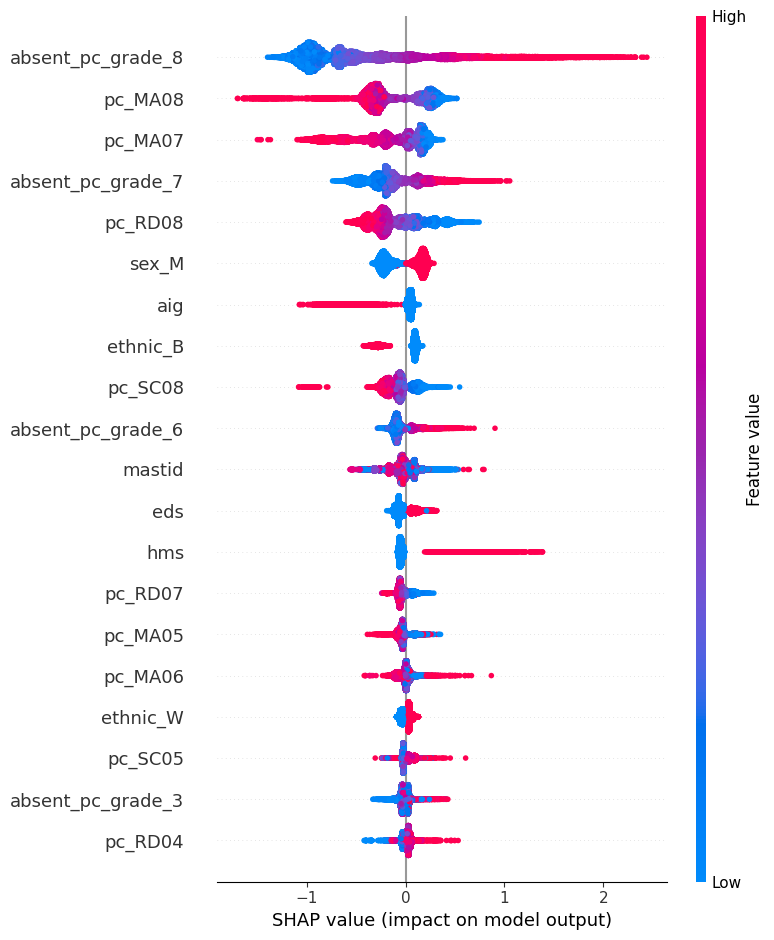

In [47]:
import shap
import xgboost as xgb

# Ensure your test data is clean and matches training features
X = X_test  # or whatever features you want to explain
dtest = xgb.DMatrix(X)

# Load SHAP TreeExplainer
explainer = shap.TreeExplainer(bst_final)

# Compute SHAP values (this can take a minute for large datasets)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)


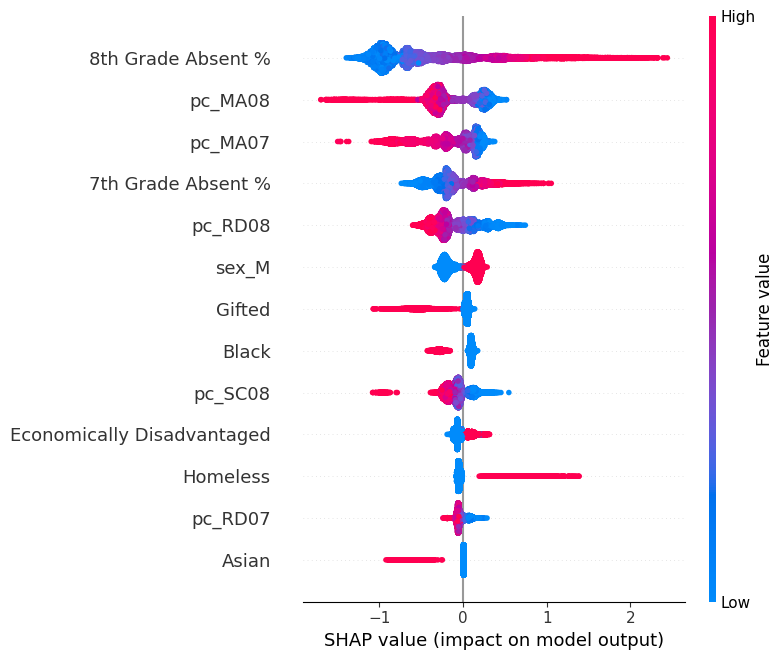

In [58]:
# Define exclusion patterns
exclude_keywords = ['lea', 'mastid', '3', '4', '5', '6','swd']

# Step 1: Filter features based on exclusion
filtered_features = [
    col for col in X.columns
    if not any(key in col for key in exclude_keywords)
]

# Step 2: Drop the last 5 features from the list
filtered_features = filtered_features[:-5]

# Define race label mapping if ethnic one-hot columns exist
ethnic_map = {
    'ethnic_A': 'Asian',
    'ethnic_B': 'Black',
    'ethnic_H': 'Hispanic',
    'ethnic_W': 'White',
    'ethnic_I': 'Indigenous',
    'ethnic_M': 'Multiracial',
    'ethnic_P': 'Pacific Islander'
}

def rename_feature(name):
    # Race one-hot columns
    if name in ethnic_map:
        return ethnic_map[name]
    # Attendance columns
    elif 'absent' in name.lower():
        for grade in range(3, 9):
            if str(grade) in name:
                return f'{grade}th Grade Absent %'
        return 'Attendance'
    elif 'hms' in name.lower():
        return 'Homeless'
    elif 'eds' in name.lower():
        return 'Economically Disadvantaged'
    elif 'aig' in name.lower():
        return 'Gifted'
    else:
        return name

# Apply renaming to filtered features
renamed_features = [rename_feature(f) for f in filtered_features]

# Plot with renamed features

# Step 3: Get indices for SHAP
filtered_indices = [X.columns.get_loc(col) for col in filtered_features]

shap.summary_plot(shap_values[:, filtered_indices], X[filtered_features], feature_names=renamed_features, plot_type='dot')


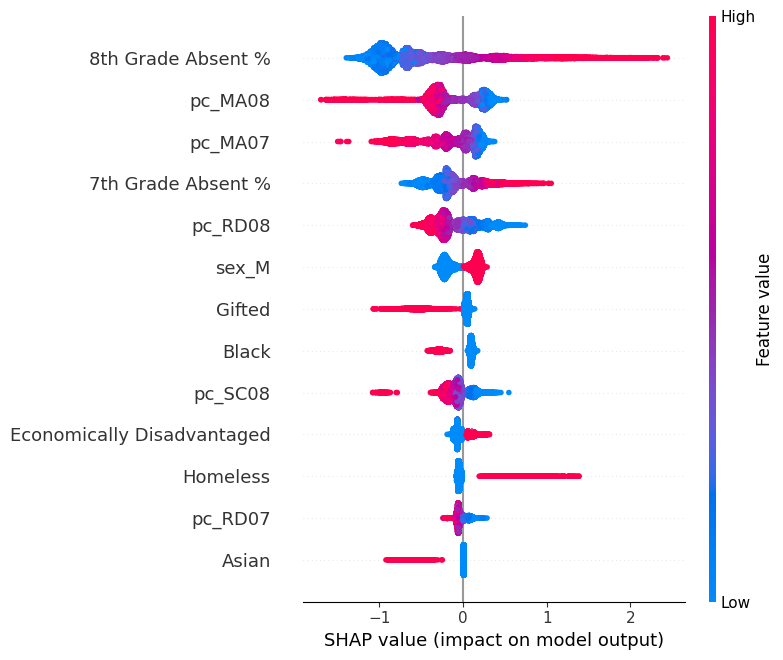